In [83]:
import torch
from pykan.kan.spline import curve2coef, coef2curve, B_batch
from pykan.kan.KAN import KAN
from torch import nn

import numpy as np
from tqdm import tqdm

In [84]:
class LAN_layer(nn.Module):
    def __init__(
        self,
        dim=2,
        num=5,
        k=3,
        noise_scale=0.1,
        scale_base=1.0,
        scale_sp=1.0,
        base_fun=torch.nn.SiLU(),
        grid_eps=0.02,
        grid_range=[-1,1],
        sp_trainable=True,
        sb_trainable=True,
        device='cpu'
    ):
        super().__init__()

        self.dim = dim
        self.num = num
        self.k = k 
        self.base_fun = base_fun
        self.device = device

        self.scale_base = scale_base
        self.scale_sp = scale_sp

        # определить grid
        self.grid = torch.einsum('i,j->ij', torch.ones(self.dim, device=device), torch.linspace(grid_range[0], grid_range[1], steps=num + 1, device=device)) # (dim, grid)
        self.grid = torch.nn.Parameter(self.grid).requires_grad_(False)

        noises = (torch.rand(self.dim, self.grid.shape[1]) - 1 / 2) * noise_scale / num
        noises = noises.to(device)
        # shape: (size, coef)
        self.coef = torch.nn.Parameter(curve2coef(self.grid, noises, self.grid, k, device))

        self.bias = nn.Linear(dim, 1, bias=False, device=device)
        self.bias.weight.data *= 0.

        self.acts_scale = torch.zeros(dim).to(self.device)

    def forward(self, x):
        # (batch, dim) -> (dim, batch)
        x = x.permute(1, 0)
        y = coef2curve(x_eval=x, grid=self.grid, coef=self.coef, k=self.k, device=self.device).permute(1, 0)  # shape (batch, dim)

        base = self.base_fun(x).permute(1, 0)  # shape (batch, dim)
        y = self.scale_base * base + self.scale_sp * y # (batch, dim)

        grid_reshape = self.grid # (dim, grid)
        input_range = grid_reshape[:, -1] - grid_reshape[:, 0] + 1e-4 # (dim, )
        output_range = torch.mean(torch.abs(y), dim=0) # (dim, )
        self.acts_scale = (output_range / input_range).to(self.device)

        return y + self.bias.weight 
    
    # def update_grid_from_samples(self, x):
    #     batch = x.shape[0]
    #     x = torch.einsum('ij,k->ikj', x, torch.ones(self.dim, ).to(self.device)).reshape(batch, self.size).permute(1, 0)
    #     x_pos = torch.sort(x, dim=1)[0]
    #     y_eval = coef2curve(x_pos, self.grid, self.coef, self.k, device=self.device)
    #     num_interval = self.grid.shape[1] - 1
    #     ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
    #     grid_adaptive = x_pos[:, ids]
    #     margin = 0.01
    #     grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) * a for a in np.linspace(0, 1, num=self.grid.shape[1])], dim=1)
    #     self.grid.data = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
    #     self.coef.data = curve2coef(x_pos, y_eval, self.grid, self.k, device=self.device)

In [85]:
device = 'cuda'

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=10, 
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=10, 
                                           shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8336941.68it/s] 


Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 215107.22it/s]


Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 506033.23it/s]


Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1577161.09it/s]

Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw



In [87]:
from pykan.kan.utils import create_dataset

f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2) + torch.sin(x[:,[0]] * x[:,[1]])
dataset = create_dataset(f, n_var=2, train_num=10000, test_num=10000)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [88]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [89]:
num = 17

model_lan = nn.Sequential(
    nn.Linear(2, 5),
    nn.BatchNorm1d(5),

    LAN_layer(5, num=num, grid_range=[-1, 1], device=device),

    nn.Linear(5, 1),
).to(device)

model_mlp = nn.Sequential(
    nn.Linear(2, 5),
    nn.BatchNorm1d(5),

    nn.Linear(5, 9),
    nn.ReLU(True),
    nn.Linear(9, 5),
    nn.ReLU(True),

    nn.Linear(5, 1),
).to(device)

model_kan = KAN(width=[2,3,1], grid=5, k=3, seed=SEED, device=device).to(device)

In [90]:
def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [91]:
get_n_params(model_lan), get_n_params(model_mlp), get_n_params(model_kan)

(136, 135, 130)

In [92]:
batch_size = 32
batch_size_test = 32
steps = 2000

optimizer_lan = torch.optim.AdamW(model_lan.parameters(), lr=1e-3)
optimizer_mlp = torch.optim.AdamW(model_mlp.parameters(), lr=1e-3)
optimizer_kan = torch.optim.AdamW(model_kan.parameters(), lr=1e-3)

loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)

In [93]:

from collections import defaultdict

pbar = tqdm(range(steps), desc='description', ncols=100)

test_losses = defaultdict(list)
train_losses = defaultdict(list)

def reg(model):
    lamb_l1 = 1.
    lamb_entropy=2.
    small_mag_threshold=1e-16
    small_reg_factor=1.
    lamb_coef=1.
    lamb_coefdiff=1.

    def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
        return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

    reg_ = 0.

    if model.__class__.__name__ == 'KAN':
        acts_scale = model.acts_scale
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(-1, )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = - torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(model.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(model.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(model.act_fun[i].coef)), dim=1))
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

    else:
        for layer in list(filter(lambda x: x.__class__.__name__ == 'LAN_layer', model)):
            vec = layer.acts_scale.reshape(-1, )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = - torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for layer in list(filter(lambda x: x.__class__.__name__ == 'LAN_layer', model)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(layer.coef), dim=1))
            coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(layer.coef)), dim=1))
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

    return reg_

def update(model, optimizer, dataset, train_id, test_id, loss_fn, loss_fn_eval, device):
    pred = model(dataset['train_input'][train_id].to(device)) 

    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device)) # + reguralize
    loss = train_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    test_loss = loss_fn_eval(model(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

    return train_loss, test_loss
        

for _ in pbar:
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

    # lan
    train_loss, test_loss = update(model_lan, optimizer_lan, dataset, train_id, test_id, loss_fn, loss_fn_eval, device)
    test_losses['lan'].append(test_loss.item())
    train_losses['lan'].append(train_loss.item())

    #mlp
    train_loss, test_loss = update(model_mlp, optimizer_mlp, dataset, train_id, test_id, loss_fn, loss_fn_eval, device)
    test_losses['mlp'].append(test_loss.item())
    train_losses['mlp'].append(train_loss.item())

    #kan
    train_loss, test_loss = update(model_kan, optimizer_kan, dataset, train_id, test_id, loss_fn, loss_fn_eval, device)
    test_losses['kan'].append(test_loss.item())
    train_losses['kan'].append(train_loss.item())

    # reg_ = reg(self.acts_scale)

description: 100%|██████████████████████████████████████████████| 2000/2000 [00:39<00:00, 50.11it/s]


In [94]:
import matplotlib.pyplot as plt

In [97]:
def plot_loss(losses, name):
    for x in losses:
        plt.plot(losses[x], label=x, alpha=0.5)
    plt.title(name)
    plt.legend()
    plt.show()

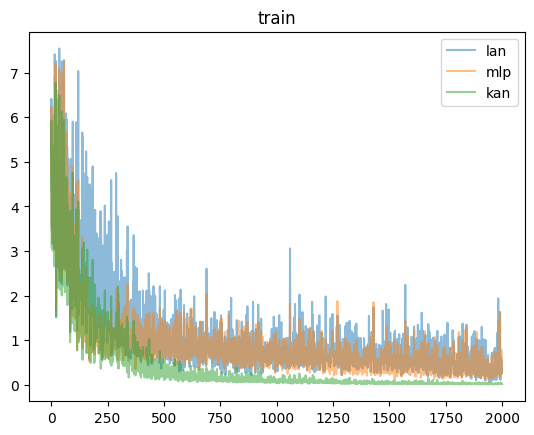

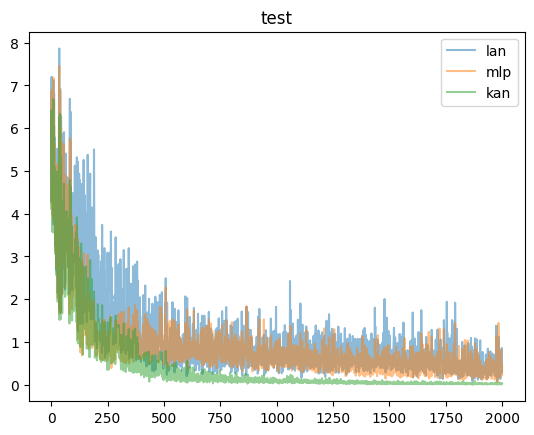

In [98]:
plot_loss(train_losses, 'train')
plot_loss(test_losses, 'test')